# Exploratory Data Analysis: Manual Annotations

This notebook analyzes the manually annotated HTML extractions from `./data/manual`.

## Overview
- **Data source**: Manual browser-based annotations using Chrome extension
- **Annotation types**: Recipes, Job Postings, Events
- **Schema**: Each annotation contains `example_html` and `expected_json` fields

## 1. Setup and Data Loading

In [21]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
import tiktoken

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print(' Libraries imported successfully!')

✓ Libraries imported successfully!


In [22]:
# Load all annotation files
data_dir = Path('../data/manual')
annotation_files = sorted(data_dir.glob('annotation_*.json'))

print(f'Found {len(annotation_files)} annotation files')

# Load annotations by type
annotations = {'recipe': [], 'job_posting': [], 'event': []}
all_annotations = []

for file_path in tqdm(annotation_files, desc='Loading annotations'):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    # Determine annotation type from filename
    if 'recipe' in file_path.name:
        anno_type = 'recipe'
    elif 'job_posting' in file_path.name:
        anno_type = 'job_posting'
    elif 'event' in file_path.name:
        anno_type = 'event'
    else:
        continue
    
    # Add metadata
    data['_type'] = anno_type
    data['_filename'] = file_path.name
    
    annotations[anno_type].append(data)
    all_annotations.append(data)

print(f'\nLoaded annotations:')
print(f'  Recipes: {len(annotations["recipe"])}')
print(f'  Job Postings: {len(annotations["job_posting"])}')
print(f'  Events: {len(annotations["event"])}')
print(f'  Total: {len(all_annotations)}')

Found 61 annotation files


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
Loading annotations:   0%|          | 0/61 [00:00<?, ?it/s]To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading annotations: 100%|██████████| 61/61 [00:00<00:00, 628.72it/s]


Loaded annotations:
  Recipes: 19
  Job Postings: 23
  Events: 19
  Total: 61


## 2. Annotation Type Distribution

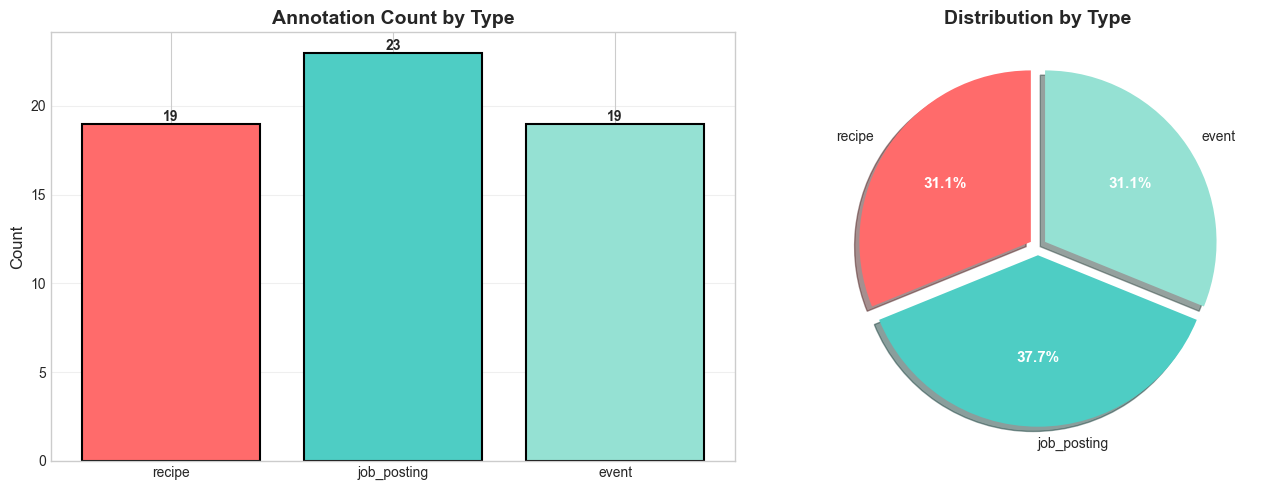

In [23]:
# Distribution by type
type_counts = {k: len(v) for k, v in annotations.items()}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
bars = ax1.bar(type_counts.keys(), type_counts.values(), 
               color=['#FF6B6B', '#4ECDC4', '#95E1D3'], 
               edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Annotation Count by Type', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2 = axes[1]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
wedges, texts, autotexts = ax2.pie(type_counts.values(), 
                                     labels=type_counts.keys(),
                                     autopct='%1.1f%%',
                                     colors=colors,
                                     explode=(0.05, 0.05, 0.05),
                                     shadow=True,
                                     startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)
ax2.set_title('Distribution by Type', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. HTML Characteristics Analysis

In [24]:
# Analyze HTML characteristics for each annotation
html_stats = []

for anno in tqdm(all_annotations, desc='Analyzing HTML'):
    html = anno['example_html']
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    
    stats = {
        'type': anno['_type'],
        'filename': anno['_filename'],
        'html_size': len(html),
        'text_length': len(text),
        'word_count': len(text.split()),
        'tag_count': len(soup.find_all()),
        'div_count': len(soup.find_all('div')),
        'span_count': len(soup.find_all('span')),
        'class_count': sum(1 for tag in soup.find_all() if tag.get('class')),
        'id_count': sum(1 for tag in soup.find_all() if tag.get('id')),
        'style_attr_count': sum(1 for tag in soup.find_all() if tag.get('style')),
        'nesting_depth': max((len(list(tag.parents)) for tag in soup.find_all()), default=0),
    }
    html_stats.append(stats)

html_df = pd.DataFrame(html_stats)

print('HTML Statistics Summary:')
print(html_df.groupby('type').agg({
    'html_size': ['mean', 'median', 'min', 'max'],
    'tag_count': ['mean', 'median'],
    'word_count': ['mean', 'median'],
    'nesting_depth': ['mean', 'max']
}).round(1))

Analyzing HTML: 100%|██████████| 61/61 [00:01<00:00, 58.74it/s]

HTML Statistics Summary:
            html_size                        tag_count        word_count  \
                 mean   median   min     max      mean median       mean   
type                                                                       
event         12649.4  11525.0  2981   25025     107.2  112.0      281.2   
job_posting   21253.7  16275.0  7657  103310     198.1  147.0      610.2   
recipe        23068.8  19647.0  8427   43797     208.3  206.0      407.7   

                   nesting_depth      
            median          mean max  
type                                  
event        298.0           8.8  13  
job_posting  626.0          11.1  24  
recipe       397.0           9.6  14  


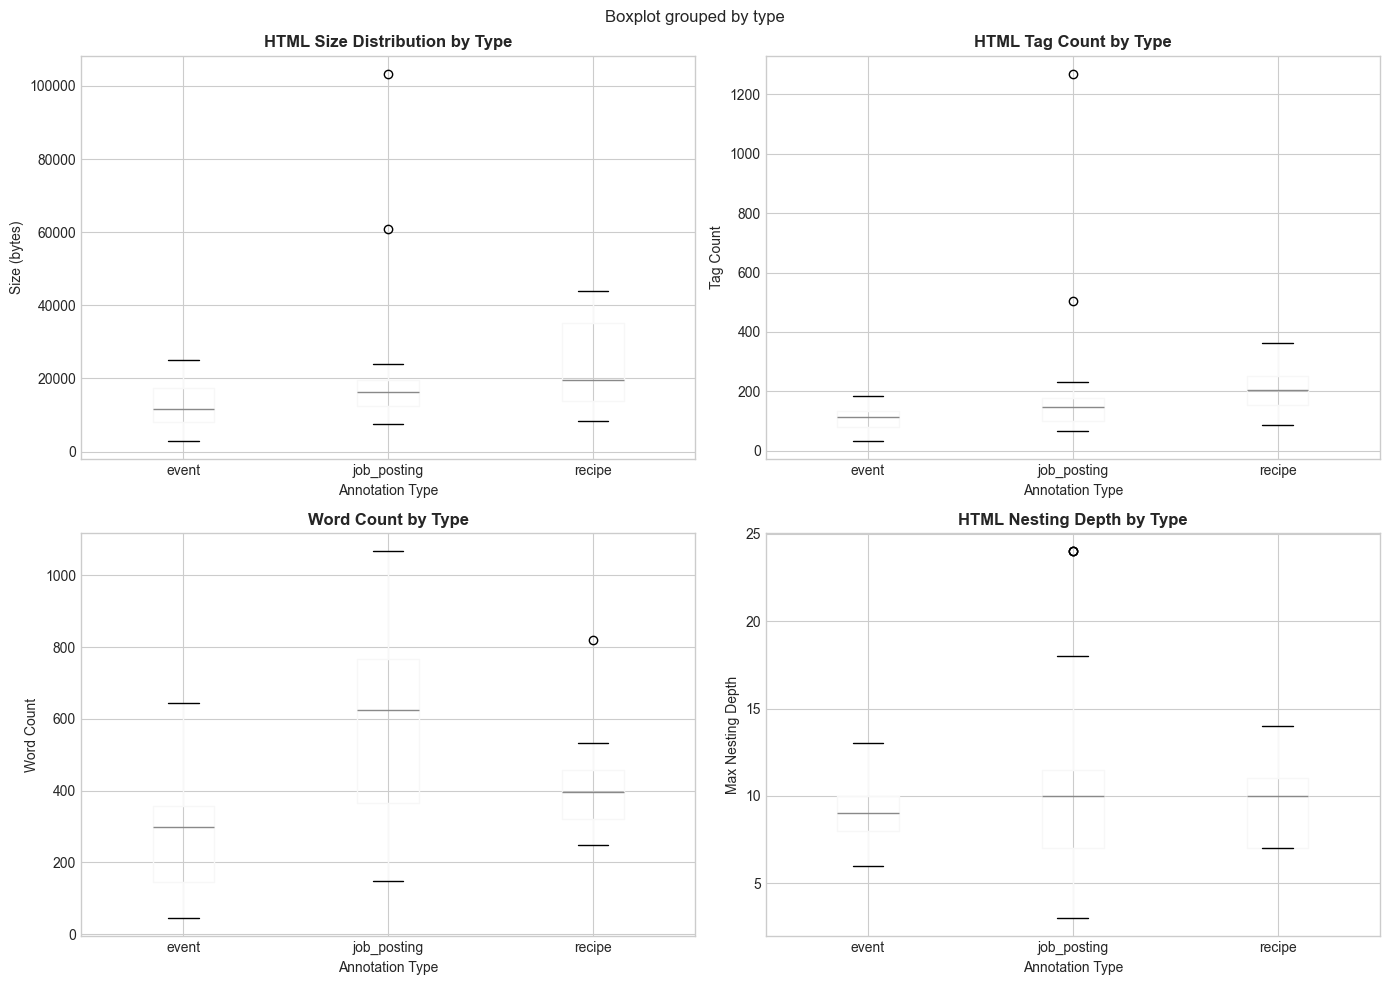

In [25]:
# Visualize HTML size distribution by type
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# HTML Size
ax1 = axes[0, 0]
html_df.boxplot(column='html_size', by='type', ax=ax1)
ax1.set_title('HTML Size Distribution by Type', fontweight='bold')
ax1.set_ylabel('Size (bytes)')
ax1.set_xlabel('Annotation Type')
plt.sca(ax1)
plt.xticks(rotation=0)

# Tag Count
ax2 = axes[0, 1]
html_df.boxplot(column='tag_count', by='type', ax=ax2)
ax2.set_title('HTML Tag Count by Type', fontweight='bold')
ax2.set_ylabel('Tag Count')
ax2.set_xlabel('Annotation Type')
plt.sca(ax2)
plt.xticks(rotation=0)

# Word Count
ax3 = axes[1, 0]
html_df.boxplot(column='word_count', by='type', ax=ax3)
ax3.set_title('Word Count by Type', fontweight='bold')
ax3.set_ylabel('Word Count')
ax3.set_xlabel('Annotation Type')
plt.sca(ax3)
plt.xticks(rotation=0)

# Nesting Depth
ax4 = axes[1, 1]
html_df.boxplot(column='nesting_depth', by='type', ax=ax4)
ax4.set_title('HTML Nesting Depth by Type', fontweight='bold')
ax4.set_ylabel('Max Nesting Depth')
ax4.set_xlabel('Annotation Type')
plt.sca(ax4)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## 4. Token Count Analysis

In [26]:
# Calculate token counts using tiktoken (cl100k_base for GPT-4)
encoding = tiktoken.get_encoding('cl100k_base')

token_stats = []
for anno in tqdm(all_annotations, desc='Calculating tokens'):
    html_tokens = len(encoding.encode(anno['example_html']))
    json_str = json.dumps(anno['expected_json'], ensure_ascii=False)
    json_tokens = len(encoding.encode(json_str))
    
    token_stats.append({
        'type': anno['_type'],
        'html_tokens': html_tokens,
        'json_tokens': json_tokens,
        'total_tokens': html_tokens + json_tokens
    })

token_df = pd.DataFrame(token_stats)

print('Token Count Statistics by Type:')
print(token_df.groupby('type').agg({
    'html_tokens': ['mean', 'median', 'min', 'max'],
    'json_tokens': ['mean', 'median', 'min', 'max'],
    'total_tokens': ['mean', 'median', 'min', 'max']
}).round(0))

print(f'\nOverall Token Statistics:')
print(f'  Total annotations: {len(token_df)}')
print(f'  Mean HTML tokens: {token_df["html_tokens"].mean():.0f}')
print(f'  Mean JSON tokens: {token_df["json_tokens"].mean():.0f}')
print(f'  Mean total tokens: {token_df["total_tokens"].mean():.0f}')

Calculating tokens: 100%|██████████| 61/61 [00:00<00:00, 438.80it/s]

Token Count Statistics by Type:
            html_tokens                      json_tokens                    \
                   mean  median   min    max        mean median  min   max   
type                                                                         
event            4167.0  3694.0  1144   8143       453.0  359.0  164   965   
job_posting      7606.0  5882.0  1766  35353       748.0  765.0  186  1433   
recipe           7403.0  5914.0  2543  19457       519.0  494.0  331   770   

            total_tokens                       
                    mean  median   min    max  
type                                           
event             4620.0  4271.0  1416   8910  
job_posting       8353.0  6901.0  2657  35875  
recipe            7921.0  6271.0  3168  19901  

Overall Token Statistics:
  Total annotations: 61
  Mean HTML tokens: 6472
  Mean JSON tokens: 584
  Mean total tokens: 7056


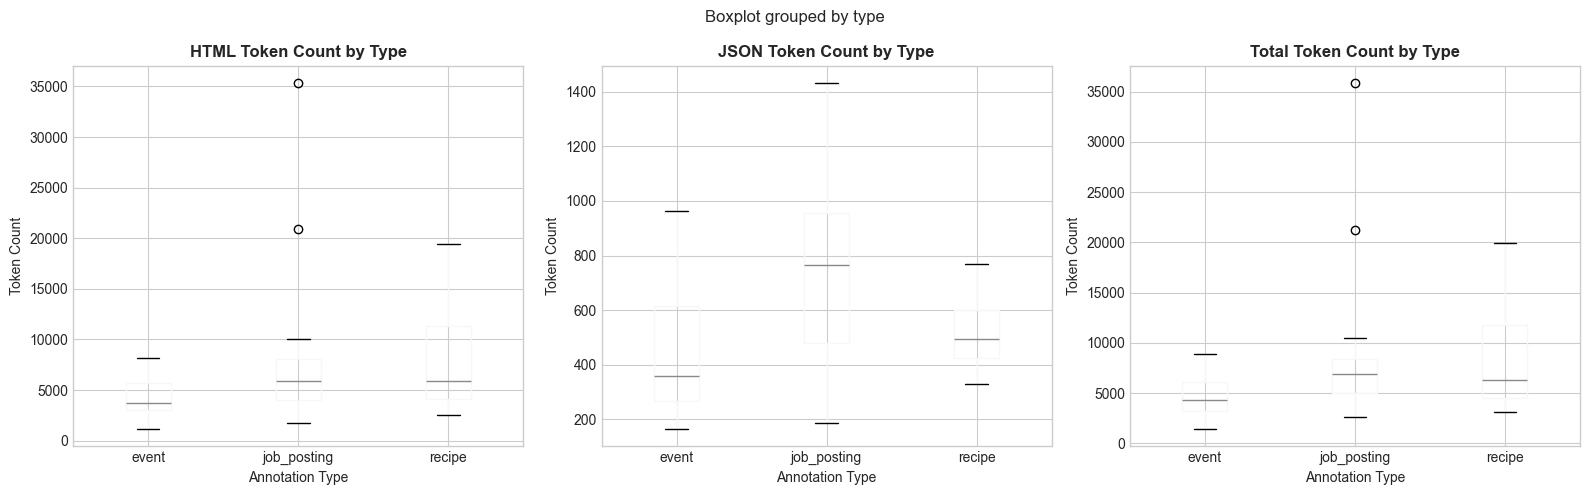

In [27]:
# Visualize token counts
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# HTML tokens by type
ax1 = axes[0]
token_df.boxplot(column='html_tokens', by='type', ax=ax1)
ax1.set_title('HTML Token Count by Type', fontweight='bold')
ax1.set_ylabel('Token Count')
ax1.set_xlabel('Annotation Type')
plt.sca(ax1)
plt.xticks(rotation=0)

# JSON tokens by type
ax2 = axes[1]
token_df.boxplot(column='json_tokens', by='type', ax=ax2)
ax2.set_title('JSON Token Count by Type', fontweight='bold')
ax2.set_ylabel('Token Count')
ax2.set_xlabel('Annotation Type')
plt.sca(ax2)
plt.xticks(rotation=0)

# Total tokens by type
ax3 = axes[2]
token_df.boxplot(column='total_tokens', by='type', ax=ax3)
ax3.set_title('Total Token Count by Type', fontweight='bold')
ax3.set_ylabel('Token Count')
ax3.set_xlabel('Annotation Type')
plt.sca(ax3)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## 5. JSON Schema Analysis

In [28]:
# Analyze JSON schemas for each type
schema_analysis = defaultdict(lambda: defaultdict(int))

for anno in all_annotations:
    anno_type = anno['_type']
    expected_json = anno['expected_json']
    
    for field, value in expected_json.items():
        schema_analysis[anno_type][field] += 1
        
        # Check for TODO or missing values
        if value == 'TODO' or value is None or value == '':
            schema_analysis[anno_type][f'{field}_missing'] = schema_analysis[anno_type].get(f'{field}_missing', 0) + 1

print('JSON Schema Field Distribution:\n')
for anno_type, fields in schema_analysis.items():
    print(f'{anno_type.upper()}:')
    # Filter out _missing fields for cleaner display
    field_counts = {k: v for k, v in fields.items() if not k.endswith('_missing')}
    for field, count in sorted(field_counts.items()):
        total = len(annotations[anno_type])
        missing_count = fields.get(f'{field}_missing', 0)
        coverage = (count - missing_count) / total * 100
        print(f'  {field}: {count}/{total} ({coverage:.1f}% complete)')
    print()

JSON Schema Field Distribution:

EVENT:
  attendee_count: 19/19 (0.0% complete)
  datetime: 19/19 (100.0% complete)
  description: 19/19 (100.0% complete)
  event_type: 19/19 (94.7% complete)
  image_url: 11/19 (57.9% complete)
  location: 19/19 (100.0% complete)
  organizer: 19/19 (78.9% complete)
  price: 19/19 (100.0% complete)
  title: 19/19 (100.0% complete)
  type: 19/19 (100.0% complete)
  venue_name: 19/19 (100.0% complete)

JOB_POSTING:
  company: 23/23 (100.0% complete)
  department: 23/23 (82.6% complete)
  description: 23/23 (100.0% complete)
  employment_type: 23/23 (91.3% complete)
  location: 23/23 (100.0% complete)
  posted_date: 23/23 (0.0% complete)
  title: 23/23 (100.0% complete)
  type: 23/23 (100.0% complete)

RECIPE:
  author: 19/19 (100.0% complete)
  cook_time: 19/19 (100.0% complete)
  description: 19/19 (89.5% complete)
  image_url: 11/19 (57.9% complete)
  ingredients: 19/19 (100.0% complete)
  instructions: 19/19 (100.0% complete)
  name: 19/19 (100.0% comp

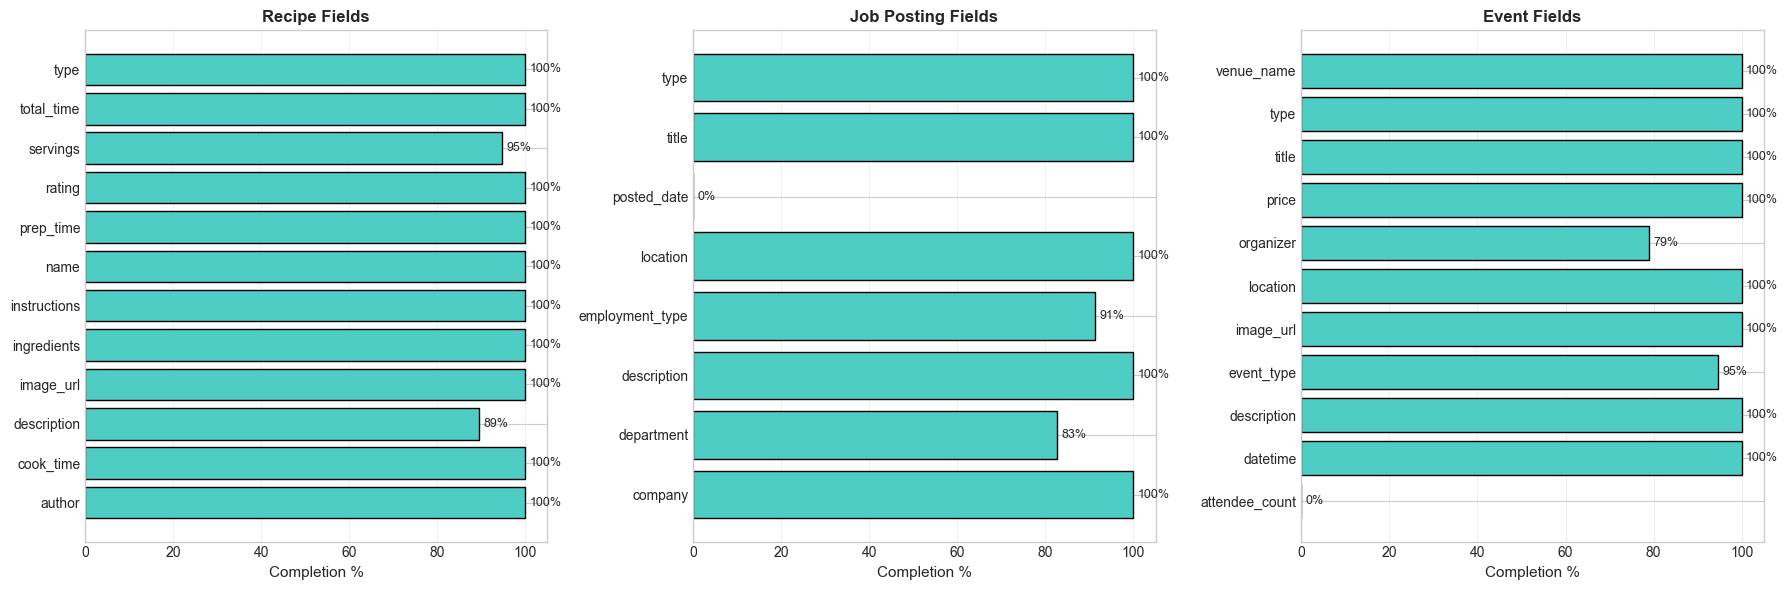

In [29]:
# Create field completeness visualization
completeness_data = []

for anno in all_annotations:
    anno_type = anno['_type']
    expected_json = anno['expected_json']
    
    for field, value in expected_json.items():
        is_complete = not (value == 'TODO' or value is None or value == '')
        completeness_data.append({
            'type': anno_type,
            'field': field,
            'complete': is_complete
        })

completeness_df = pd.DataFrame(completeness_data)

# Calculate completion rate by field and type
completion_rates = completeness_df.groupby(['type', 'field'])['complete'].mean().reset_index()
completion_rates['completion_pct'] = completion_rates['complete'] * 100

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, anno_type in enumerate(['recipe', 'job_posting', 'event']):
    ax = axes[idx]
    type_data = completion_rates[completion_rates['type'] == anno_type]
    
    bars = ax.barh(type_data['field'], type_data['completion_pct'], 
                   color='#4ECDC4', edgecolor='black')
    ax.set_xlabel('Completion %', fontsize=11)
    ax.set_title(f'{anno_type.replace("_", " ").title()} Fields', 
                 fontsize=12, fontweight='bold')
    ax.set_xlim(0, 105)
    ax.grid(axis='x', alpha=0.3)
    
    for bar, pct in zip(bars, type_data['completion_pct']):
        ax.text(pct + 1, bar.get_y() + bar.get_height()/2, 
                f'{pct:.0f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Content Quality Metrics

In [30]:
# Analyze content quality for each type
quality_metrics = []

for anno in all_annotations:
    anno_type = anno['_type']
    expected_json = anno['expected_json']
    
    # Type-specific metrics
    metrics = {'type': anno_type}
    
    if anno_type == 'recipe':
        metrics['has_ingredients'] = bool(expected_json.get('ingredients'))
        metrics['ingredient_count'] = len(expected_json.get('ingredients', []))
        metrics['has_instructions'] = bool(expected_json.get('instructions'))
        metrics['instruction_count'] = len(expected_json.get('instructions', []))
        metrics['has_timing'] = bool(expected_json.get('cook_time') or expected_json.get('prep_time'))
        metrics['has_rating'] = bool(expected_json.get('rating'))
        
    elif anno_type == 'job_posting':
        metrics['has_title'] = bool(expected_json.get('title') and expected_json.get('title') != 'TODO')
        metrics['has_company'] = bool(expected_json.get('company'))
        metrics['has_location'] = bool(expected_json.get('location'))
        metrics['has_description'] = bool(expected_json.get('description'))
        desc_length = len(expected_json.get('description', ''))
        metrics['description_length'] = desc_length
        
    elif anno_type == 'event':
        metrics['has_title'] = bool(expected_json.get('title'))
        metrics['has_datetime'] = bool(expected_json.get('datetime') and expected_json.get('datetime') != 'TODO')
        metrics['has_location'] = bool(expected_json.get('location'))
        metrics['has_price'] = bool(expected_json.get('price'))
        metrics['has_description'] = bool(expected_json.get('description'))
        
    quality_metrics.append(metrics)

quality_df = pd.DataFrame(quality_metrics)

print('Content Quality Summary:\n')
for anno_type in ['recipe', 'job_posting', 'event']:
    type_data = quality_df[quality_df['type'] == anno_type]
    print(f'{anno_type.upper()}:')
    for col in type_data.columns:
        if col != 'type' and type_data[col].dtype == bool:
            pct = type_data[col].sum() / len(type_data) * 100
            print(f'  {col}: {pct:.1f}%')
        elif col != 'type' and col.endswith('_count') or col.endswith('_length'):
            print(f'  {col}: mean={type_data[col].mean():.1f}, median={type_data[col].median():.1f}')
    print()

Content Quality Summary:

RECIPE:
  description_length: mean=nan, median=nan
  ingredient_count: mean=7.4, median=9.0
  instruction_count: mean=5.1, median=6.0

JOB_POSTING:
  description_length: mean=3457.1, median=3783.0
  ingredient_count: mean=nan, median=nan
  instruction_count: mean=nan, median=nan

EVENT:
  description_length: mean=nan, median=nan
  ingredient_count: mean=nan, median=nan
  instruction_count: mean=nan, median=nan



/Users/shuisongluar/projects/c4ai-crawlerlm/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shuisongluar/projects/c4ai-crawlerlm/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shuisongluar/projects/c4ai-crawlerlm/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shuisongluar/projects/c4ai-crawlerlm/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shuisongluar/projects/c4ai-crawlerlm/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  retur

## 7. Summary Statistics

In [31]:
# Overall dataset summary
print('=' * 60)
print('MANUAL ANNOTATION DATASET SUMMARY')
print('=' * 60)
print(f'\nTotal Annotations: {len(all_annotations)}')
print(f'  Recipes: {len(annotations["recipe"])} ({len(annotations["recipe"])/len(all_annotations)*100:.1f}%)')
print(f'  Job Postings: {len(annotations["job_posting"])} ({len(annotations["job_posting"])/len(all_annotations)*100:.1f}%)')
print(f'  Events: {len(annotations["event"])} ({len(annotations["event"])/len(all_annotations)*100:.1f}%)')

print(f'\nHTML Characteristics:')
print(f'  Mean HTML size: {html_df["html_size"].mean():.0f} bytes')
print(f'  Mean tag count: {html_df["tag_count"].mean():.0f}')
print(f'  Mean word count: {html_df["word_count"].mean():.0f}')
print(f'  Mean nesting depth: {html_df["nesting_depth"].mean():.1f}')

print(f'\nToken Statistics:')
print(f'  Mean HTML tokens: {token_df["html_tokens"].mean():.0f}')
print(f'  Mean JSON tokens: {token_df["json_tokens"].mean():.0f}')
print(f'  Mean total tokens per example: {token_df["total_tokens"].mean():.0f}')
print(f'  Total corpus tokens: {token_df["total_tokens"].sum():,.0f}')

# Estimate context window requirements
max_tokens = token_df['total_tokens'].max()
p95_tokens = token_df['total_tokens'].quantile(0.95)
print(f'\nContext Window Requirements:')
print(f'  95th percentile: {p95_tokens:.0f} tokens')
print(f'  Maximum: {max_tokens:.0f} tokens')
print(f'  Recommended minimum context: {int(np.ceil(p95_tokens / 1000) * 1000)}K tokens')
print('=' * 60)

MANUAL ANNOTATION DATASET SUMMARY

Total Annotations: 61
  Recipes: 19 (31.1%)
  Job Postings: 23 (37.7%)
  Events: 19 (31.1%)

HTML Characteristics:
  Mean HTML size: 19139 bytes
  Mean tag count: 173
  Mean word count: 445
  Mean nesting depth: 9.9

Token Statistics:
  Mean HTML tokens: 6472
  Mean JSON tokens: 584
  Mean total tokens per example: 7056
  Total corpus tokens: 430,413

Context Window Requirements:
  95th percentile: 13469 tokens
  Maximum: 35875 tokens
  Recommended minimum context: 14000K tokens


## Next Steps

Based on this EDA, the manual annotation dataset shows:
- **Good distribution** across three distinct content types
- **Reasonable HTML complexity** with varying sizes and nesting depths
- **Structured schemas** for each annotation type with varying field completeness
- **Manageable token counts** suitable for fine-tuning small models

### Recommendations:
1. Address any TODO or missing fields in the JSON extractions
2. Consider augmentation strategies to increase dataset size
3. Create train/val/test splits stratified by annotation type
4. Convert to chat format for model fine-tuning